[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PetiteIA/schema_mechanism/blob/master/notebooks/agent8.ipynb)

# THE AGENT WHO REVERSED HIS DECISION

# Learning objectives

Upon completing this lab, you will be able to implement a developmental agent that selects an action based on the anticipation of the two next steps.

# Adapt the decision mechanism

Let's include the decision in the composite interaction. 
A composite interaction becomes a tuple (pre-interaction, decision, post-interaction).

At the end of time step $t$, the agent records or reinforces the interactions:

* $(i_{t-2}, d_{t-1}, i_{t-1})$
* $((i_{t-3}, d_{t-2}, i_{t-2}), d_{t-1}, i_{t-1})$
* $(i_{t-3}, d^2, (i_{t-2}, d_{t-1}, i_{t-1}))$
* $((i_{t-4}, d_{t-3}, i_{t-3}), d^2, (i_{t-2}, d_{t-1}, i_{t-1}))$

If it does not yet exist, the new decision $d^2$ is constructed different from the decision $d_{t-2}$ that was actually made at time $t-2$. 
For example, if the agent made decision $d_{t-2} = a0$ and enacted interaction $i_{t-2}=i00$, and then made decision $d_{t-1} = a0$, and enacted interaction $i_{t-1}=i01$, the agent learns the new decision $d^2=i00a0$ consisting of trying to enact the interaction $i_t=i00$ and then do action $a_{t+1}=a0.$

![Agent5](img/Figure_1_Agent8.svg)

The purpose of including the decision in the composite interaction is to learn that the agent may fail to enact a decision. 

For example, in the context of having enacted interaction $i01$, the agent may select decision $i10a0$ but may fail to enat $i10$ and enact $i11$ instead. In this case, the agent learns the composite interaction $(i01, i10a0, i11)$.

When the agent encounters the context $i01$ again, it will have a better assessment of the expected valence of decision $i10a0$ by taking its probabilities of success and failure into account. 

# Define the necessary classes

Ensure the required packages are installed if they aren't already.

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install ipywidgets


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## The primitive interaction class

A primitive interaction's decision is its action.

In [1]:
class Interaction:
    """An interaction is a tuple (action, outcome) with a valence"""
    def __init__(self, _action, _outcome, _valence):
        self._action = _action
        self._outcome = _outcome
        self._valence = _valence

    def get_action(self):
        """Return the action"""
        return self._action

    def get_decision(self):
        """Return the decision key"""
        return f"a{self._action}"

    def get_primitive_action(self):
        """Return the action for compatibility with CompositeInteraction"""
        return self._action

    def get_outcome(self):
        """Return the action"""
        return self._outcome

    def get_valence(self):
        """Return the action"""
        return self._valence

    def key(self):
        """ The key to find this interaction in the dictinary is the string '<action><outcome>'. """
        return f"{self._action}{self._outcome}"

    def pre_key(self):
        """Return the key. Used for compatibility with CompositeInteraction"""
        return self.key()

    def __str__(self):
        """ Print interaction in the form '<action><outcome:<valence>' for debug."""
        return f"{self._action}{self._outcome}:{self._valence}"

    def __eq__(self, other):
        """ Interactions are equal if they have the same key """
        if isinstance(other, self.__class__):
            return self.key() == other.key()
        else:
            return False

## The composite interaction class

A composite interaction is initialized with a tuple (pre_interaction, decision, post_interaction)

In [2]:
class CompositeInteraction:
    """A composite interaction is a tuple (pre_interaction, decision, post_interaction) and a weight"""
    def __init__(self, pre_interaction, decision, post_interaction):
        self.pre_interaction = pre_interaction
        self.decision = decision
        self.post_interaction = post_interaction
        self.weight = 1
        self.isActivated = False

    def get_decision(self):
        """Return the sequence of decisions"""
        return self.decision
        return f"{self.pre_interaction.key()}{self.post_interaction.get_decision()}"

    def get_primitive_action(self):
        """Return the primitive action"""
        return self.pre_interaction.get_primitive_action()

    def get_valence(self):
        """Return the valence of the pre_interaction plus the valence of the post_interaction"""
        return self.pre_interaction.get_valence() + self.post_interaction.get_valence()

    def reinforce(self):
        """Increment the composite interaction's weight"""
        self.weight += 1

    def key(self):
        """ The key to find this interaction in the dictionary is the string
        '<pre_interaction>,<decision>,<post_interaction>'. """
        # return f"({self.pre_interaction.key()},{self.post_interaction.key()})"
        return f"({self.pre_interaction.key()},{self.decision},{self.post_interaction.key()})"

    def pre_key(self):
        """Return the key of the pre_interaction"""
        return self.pre_interaction.pre_key()
        
    def __str__(self):
        """ Print the interaction in the Newick tree format (pre_interaction, post_interaction: valence) """
        return f"({self.pre_interaction}, {self.decision}, {self.post_interaction}: {self.weight})"

    def __eq__(self, other):
        """ Interactions are equal if they have the same keys """
        if isinstance(other, self.__class__):
            return self.key() == other.key()
        else:
            return False

## Define the Agent class

In [3]:
import pandas as pd
import numpy as np

class Agent:
    def __init__(self, _interactions):
        """ Initialize our agent """
        self._interactions = {interaction.key(): interaction for interaction in _interactions}
        self._composite_interactions = {}
        self._intended_interaction = self._interactions["00"]
        self._decision = None  # "0"
        self._last_interaction = None
        self._previous_interaction = None
        self._penultimate_interaction = None
        self._last_composite_interaction = None
        self._previous_composite_interaction = None
        self._penultimate_composite_interaction = None
        # Create a dataframe of default primitive interactions
        default_interactions = [interaction for interaction in _interactions if interaction.get_outcome() == 0]
        data = {'activated': [np.nan] * len(default_interactions),
                'weight': [0] * len(default_interactions),
                # 'action': [i.get_primitive_action() for i in default_interactions],
                'post_interaction': [i.key() for i in default_interactions],
                'valence': [i.get_valence() for i in default_interactions],
                'decision': [i.get_decision() for i in default_interactions],
                'proclivity': [0] * len(default_interactions),
                'primitive': [i.key() for i in default_interactions]
               }
        self.primitive_df = pd.DataFrame(data)
        # Store the selection dataframe as a class attribute so we can display it in the notebook
        self.proposed_df = None

    def action(self, _outcome):
        """Implement the agent's policy"""
        # Memorize the context
        self._penultimate_composite_interaction = self._previous_composite_interaction
        self._previous_composite_interaction = self._last_composite_interaction
        self._penultimate_interaction = self._previous_interaction
        self._previous_interaction = self._last_interaction
        self._last_interaction = self._interactions[f"{self._intended_interaction.get_action()}{_outcome}"]

        # tracing the previous cycle
        print(
            f"Action: {self._intended_interaction.get_action()}, Prediction: {self._intended_interaction.get_outcome()}, "
            f"Outcome: {_outcome}, Prediction_correct: {self._intended_interaction.get_outcome() == _outcome}, "
            f"Valence: {self._last_interaction.get_valence()}")

        # Call the learning mechanism
        self.learn()

        # Create the proposed dataframe
        self.create_proposed_df()
        self.aggregate_propositions()

        # Select the intended primitive interaction
        self.decide()

        return self._intended_interaction.get_action()

    def learn(self):
        """Learn the composite interactions"""
        # First level of composite interactions using the last primitive decision
        self._last_composite_interaction = self.learn_composite_interaction(
            self._previous_interaction, self._last_interaction.get_decision(), self._last_interaction)
        # self._last_composite_interaction = self.learn_composite_interaction(
        #     self._previous_interaction, self._decision, self._last_interaction)

        # Second level of composite interactions 
        self.learn_composite_interaction(self._previous_composite_interaction, self._last_interaction.get_decision(),
                                         self._last_interaction)
        # self.learn_composite_interaction(
        #     self._previous_composite_interaction, self._decision, self._last_interaction)

        if self._last_composite_interaction is not None:
            # Possibly create a new composite decision
            decision = f"{self._last_composite_interaction.pre_interaction.key()}{self._last_composite_interaction.post_interaction.get_decision()}"
            self.learn_composite_interaction(self._penultimate_interaction, decision, self._last_composite_interaction)
            # self.learn_composite_interaction(self._penultimate_interaction, self._decision, self._last_composite_interaction)
            self.learn_composite_interaction(self._penultimate_composite_interaction, decision, self._last_composite_interaction)

    def learn_composite_interaction(self, pre_interaction, decision, post_interaction):
        """Record or reinforce the composite interaction made of (pre_interaction, post_interaction)"""
        if pre_interaction is None:
            return None
        else:
            # If the pre interaction exist
            composite_interaction = CompositeInteraction(pre_interaction, decision, post_interaction)
            if composite_interaction.key() not in self._composite_interactions:
                # Add the composite interaction to memory
                self._composite_interactions[composite_interaction.key()] = composite_interaction
                print(f"Learning {composite_interaction}")
                return composite_interaction
            else:
                # Reinforce the existing composite interaction and return it
                self._composite_interactions[composite_interaction.key()].reinforce()
                print(f"Reinforcing {self._composite_interactions[composite_interaction.key()]}")
                return self._composite_interactions[composite_interaction.key()]

    def create_proposed_df(self):
        """Create the proposed dataframe from the activated interactions"""
        # The list of activated interaction that match the current context
        activated_keys = [composite_interaction.key() for composite_interaction in
                          self._composite_interactions.values()
                          if composite_interaction.pre_interaction == self._last_interaction or
                          composite_interaction.pre_interaction == self._last_composite_interaction]
        data = {'activated': activated_keys,
                'weight': [self._composite_interactions[k].weight for k in activated_keys],
                # 'action': [self._composite_interactions[k].post_interaction.get_primitive_action() for k in
                #            activated_keys],
                'post_interaction': [self._composite_interactions[k].post_interaction.key() for k in activated_keys],
                'valence': [self._composite_interactions[k].post_interaction.get_valence() for k in activated_keys],
                'decision': [self._composite_interactions[k].get_decision() for k in activated_keys],
                'primitive': [self._composite_interactions[k].post_interaction.pre_key() for k in activated_keys]
                }
        activated_df = pd.DataFrame(data)

        # Create the selection dataframe from the primitive and the activated dataframes
        self.proposed_df = pd.concat([self.primitive_df, activated_df], ignore_index=True)

        # # Compute the proclivity for each proposition
        self.proposed_df['proclivity'] = self.proposed_df['weight'] * self.proposed_df['valence']

    def aggregate_propositions(self):
        """Aggregate the proclivity"""
        # Compute the proclivity for each action
        grouped_df = self.proposed_df.groupby('decision').agg({'proclivity': 'sum'}).reset_index()
        self.proposed_df = self.proposed_df.merge(grouped_df, on='decision', suffixes=('', '_agg'))
        # Sort by descending order of proclivity
        self.proposed_df = self.proposed_df.sort_values(by=['proclivity_agg', 'decision'], ascending=[False, False])

        # Find the most probable primitive interaction for each action
        max_weight_df = self.proposed_df.loc[
            self.proposed_df.groupby('decision')['weight'].idxmax(), ['decision', 'primitive']].reset_index(
            drop=True)
        max_weight_df.columns = ['decision', 'intended']
        self.proposed_df = self.proposed_df.merge(max_weight_df, on='decision')

    def decide(self):
        """Selects the intended interaction from the proposed dataframe"""
        # Find the first row that has the highest proclivity
        max_index = self.proposed_df['proclivity_agg'].idxmax()
        self._decision = self.proposed_df.loc[max_index, ['decision']].values[0]

        # Find the intended interaction corresponding to the action that has the highest proclivity
        intended_interaction_key = self.proposed_df.loc[max_index, ['intended']].values[0]
        self._intended_interaction = self._interactions[intended_interaction_key]
        print(f"Decision {self._decision}, Intended {self._intended_interaction}")

# PRELIMINARY EXERCISE

## Test the agent in Environment 6

In [4]:
import matplotlib.pyplot as plt
from ipywidgets import Output
from IPython.display import display
from matplotlib.colors import ListedColormap, BoundaryNorm

class Environment6:
    """ The grid """
    def __init__(self):
        """ Initialize the grid """
        self.grid = np.array([[1, 0, 0, 1]])
        self.position = 1

    def outcome(self, _action):
        """Take the action and generate the next outcome """
        if _action == 0:
            # Move left
            if self.position > 1:
                # No bump
                self.position -= 1
                self.grid[0, -1] = 1
                _outcome = 0
            elif self.grid[0, 0] == 1:
                # First bump
                _outcome = 1
                self.grid[0, 0] = 2
            else:
                # Subsequent bumps
                _outcome = 0
        else:
            # Move right
            if self.position < self.grid.shape[1] - 2:
                # No bump
                self.position += 1
                self.grid[0, 0] = 1
                _outcome = 0
            elif self.grid[0, -1] == 1:
                # First bump
                _outcome = 1
                self.grid[0, -1] = 2
            else:
                # Subsequent bumps
                _outcome = 0
        return _outcome
        
    def display(self):
        """Display the grid"""
        out.clear_output(wait=True)
        cmap = ListedColormap(['white', 'lightgreen', 'green'])
        # Set up boundaries for color mapping (adjusts range for each value)
        norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
        with out:
            fig, ax = plt.subplots()
            # Hide the ticks
            ax.set_xticks([])
            ax.set_yticks([])
            # Display the grid
            ax.imshow(self.grid, cmap=cmap, norm=norm)
            # ax.imshow(self.grid, cmap=cmap.N, vmin=0, vmax=3)
            plt.scatter(self.position, 0, s=1000)
            plt.show()

In [5]:
# Instanciate a new agent
interactions = [
    Interaction(0,0,-1),
    Interaction(0,1,1),
    Interaction(1,0,-1),
    Interaction(1,1,1)
]
a = Agent(interactions)
e = Environment6()

# Output widget for displaying the plot
out = Output()

# Run the interaction loop
step = 0
outcome = 0

Run the simulation step by step to see the environment and the proposed DataFrame. Use `Ctrl+Enter` to run the cell bellow and stay on it.

In [33]:
print(f"Step {step}")
step += 1
e.display()
display(out)
action = a.action(outcome)
outcome = e.outcome(action)
a.proposed_df

Step 27


Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 640x480 with 1 Axes>', 'i…

Action: 1, Prediction: 0, Outcome: 0, Prediction_correct: True, Valence: -1
Reinforcing (01:1, a1, 10:-1: 4)
Reinforcing ((00:-1, a0, 01:1: 5), a1, 10:-1: 4)
Reinforcing (00:-1, 01a1, (01:1, a1, 10:-1: 4): 4)
Reinforcing ((11:1, a0, 00:-1: 4), 01a1, (01:1, a1, 10:-1: 4): 3)
Decision a1, Intended 11:1


,activated,weight,post_interaction,valence,decision,proclivity,primitive,proclivity_agg,intended
0,NaN,0,10,-1,a1,0,10,6,11
1,"(10,a1,11)",5,11,1,a1,5,11,6,11
2,"(10,a1,10)",2,10,-1,a1,-2,10,6,11
3,"((01,a1,10),a1,11)",3,11,1,a1,3,11,6,11
4,"(10,11a1,(11,a1,10))",1,"(11,a1,10)",0,11a1,0,11,0,11
5,"(10,11a0,(11,a0,00))",4,"(11,a0,00)",0,11a0,0,11,0,11
6,"((01,a1,10),11a0,(11,a0,00))",3,"(11,a0,00)",0,11a0,0,11,0,11
7,"(10,00a0,(00,a0,01))",1,"(00,a0,01)",0,00a0,0,00,0,00
8,NaN,0,00,-1,a0,0,00,-1,00
9,"(10,a0,00)",1,00,-1,a0,-1,00,-1,00


Observe that the agent learns to enact the positive interaction every second step, which is the best it can get in Environment6.

## Let's Create Environment7

Environment7 is similar to Environment6 but one cell wider.

In [34]:
class Environment7(Environment6):
    def __init__(self):
        """ Initialize the grid """
        self.grid = np.array([[1, 0, 0, 0, 1]])
        self.position = 1 

In [35]:
# Instanciate a new agent
interactions = [
    Interaction(0,0,-1),
    Interaction(0,1,1),
    Interaction(1,0,-1),
    Interaction(1,1,1)
]
a = Agent(interactions)
e = Environment7()

# Output widget for displaying the plot
out = Output()

# Run the interaction loop
step = 0
outcome = 0

Run the simulation step by step to see Environment7 and the proposed DataFrame. Use Ctrl+Enter to run the cell bellow and stay on it.

In [38]:
print(f"Step {step}")
step += 1
e.display()
display(out)
action = a.action(outcome)
outcome = e.outcome(action)
a.proposed_df

Step 2


Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 640x480 with 1 Axes>', 'i…

Action: 1, Prediction: 0, Outcome: 0, Prediction_correct: True, Valence: -1
Learning (10:-1, a1, 10:-1: 1)
Learning ((00:-1, a1, 10:-1: 1), a1, 10:-1: 1)
Learning (00:-1, 10a1, (10:-1, a1, 10:-1: 1): 1)
Decision a0, Intended 00:-1


,activated,weight,post_interaction,valence,decision,proclivity,primitive,proclivity_agg,intended
0,NaN,0,00,-1,a0,0,00,0,00
1,NaN,0,10,-1,a1,0,10,-1,10
2,"(10,a1,10)",1,10,-1,a1,-1,10,-1,10


# Assignment 

# Create Agent 8

Modify the `learn()` method to record composite interaction from previous composite decisions

It must keeps track of decisions that failed to enact and take them into account in making the next decision.


When the post_interaction is a primitive interaction, the decision is always this post_interaction's action. When the post_interaction is a composite interaction, however, the decision may be a sequence

In [4]:
class Agent8(Agent):
    def learn(self):
        """Learn the composite interactions"""
        # First level of composite interactions using the last primitive decision
        # self._last_composite_interaction = self.learn_composite_interaction(
        #     self._previous_interaction, self._last_interaction.get_decision(), self._last_interaction)
        self._last_composite_interaction = self.learn_composite_interaction(
            self._previous_interaction, self._decision, self._last_interaction)

        # Second level of composite interactions 
        # self.learn_composite_interaction(self._previous_composite_interaction, self._last_interaction.get_decision(),
        #                                  self._last_interaction)
        self.learn_composite_interaction(
            self._previous_composite_interaction, self._decision, self._last_interaction)

        if self._last_composite_interaction is not None:
            # Possibly create a new composite decision
            decision = f"{self._last_composite_interaction.pre_interaction.key()}{self._last_composite_interaction.post_interaction.get_decision()}"
            self.learn_composite_interaction(self._penultimate_interaction, decision, self._last_composite_interaction)
            # self.learn_composite_interaction(self._penultimate_interaction, self._decision, self._last_composite_interaction)
            self.learn_composite_interaction(self._penultimate_composite_interaction, decision, self._last_composite_interaction)

    def decide(self):
        """Selects the intended interaction from the proposed dataframe"""

        # Remove the proposed post_interaction that have a low weight
        to_remove = set()
        for i, k in self.proposed_df["post_interaction"].items():
            if k in self._composite_interactions and self._composite_interactions[k].weight <= 4:
                to_remove.add(i)
        self.proposed_df = self.proposed_df.drop(index=to_remove)

        # Find the first row that has the highest proclivity
        max_index = self.proposed_df['proclivity_agg'].idxmax()
        self._decision = self.proposed_df.loc[max_index, ['decision']].values[0]

        # Find the intended interaction corresponding to the action that has the highest proclivity
        intended_interaction_key = self.proposed_df.loc[max_index, ['intended']].values[0]
        self._intended_interaction = self._interactions[intended_interaction_key]
        print(f"Decision {self._decision}, Intended {self._intended_interaction}")

## Test Agent8 in Environment7

In [1082]:
# Instanciate a new agent
interactions = [
    Interaction(0,0,-1),
    Interaction(0,1,1),
    Interaction(1,0,-1),
    Interaction(1,1,1)
]
a = Agent8(interactions)
e = Environment7()

# Output widget for displaying the plot
out = Output()

# Run the interaction loop
step = 0
outcome = 0

In [1124]:
print(f"Step {step}")
step += 1
e.display()
display(out)
action = a.action(outcome)
outcome = e.outcome(action)
a.proposed_df

Step 41


Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 640x480 with 1 Axes>', 'i…

Action: 0, Prediction: 0, Outcome: 1, Prediction_correct: False, Valence: 1
Reinforcing (00:-1, a0, 01:1: 4)
Reinforcing ((00:-1, a0, 00:-1: 7), a0, 01:1: 3)
Reinforcing (00:-1, 00a0, (00:-1, a0, 01:1: 4): 3)
Learning ((10:-1, 00a0, 00:-1: 1), 00a0, (00:-1, a0, 01:1: 4): 1)
Decision a0, Intended 00:-1


,activated,weight,post_interaction,valence,decision,proclivity,primitive,proclivity_agg,intended
0,NaN,0,00,-1,a0,0,00,-2,00
1,"(01,a0,00)",1,00,-1,a0,-1,00,-2,00
2,"((00,a0,01),a0,00)",1,00,-1,a0,-1,00,-2,00
3,NaN,0,10,-1,a1,0,10,-4,10
4,"(01,a1,10)",2,10,-1,a1,-2,10,-4,10
5,"((00,a0,01),a1,10)",2,10,-1,a1,-2,10,-4,10
6,"(01,10a1,(10,a1,10))",1,"(10,a1,10)",-2,10a1,-2,10,-4,10
7,"((00,a0,01),10a1,(10,a1,10))",1,"(10,a1,10)",-2,10a1,-2,10,-4,10
8,"(01,10a0,(10,a0,00))",1,"(10,a0,00)",-2,10a0,-2,10,-4,10
9,"((00,a0,01),10a0,(10,a0,00))",1,"(10,a0,00)",-2,10a0,-2,10,-4,10


## Environment8

In [174]:
import matplotlib.pyplot as plt
from ipywidgets import Output
from IPython.display import display

class Environment8:
    """ The grid """
    def __init__(self):
        """ Initialize the grid and the agent's pose """
        self.grid = np.array([[1, 0, 0, 1]])
        self.position = 1
        self.direction = 0

    def outcome(self, action):
        """Take the action and generate the next outcome """
        if action == 0:
            # Move forward
            if self.direction == 0:
                # Move to the left
                if self.position > 1:
                    # No bump
                    self.position -= 1
                    self.grid[0, 3] = 1
                    outcome = 0
                elif self.grid[0, 0] == 1:
                    # First bump
                    outcome = 1
                    self.grid[0, 0] = 2
                else:
                    # Subsequent bumps
                    outcome = 0
            else:
                # Move to the right
                if self.position < 2:
                    # No bump
                    self.position += 1
                    self.grid[0, 0] = 1
                    outcome = 0
                elif self.grid[0, 3] == 1:
                    # First bump
                    outcome = 1
                    self.grid[0, 3] = 2
                else:
                    # Subsequent bumps
                    outcome = 0
        else:
            # Turn 180°
            outcome = 0
            if self.direction == 0:
                self.direction = 1
            else:
                self.direction = 0
        return outcome  

    def display(self):
        """Display the grid"""
        out.clear_output(wait=True)
        with out:
            fig, ax = plt.subplots()
            # Hide the ticks
            ax.set_xticks([])
            ax.set_yticks([])
            # Display the grid
            ax.imshow(self.grid, cmap='Greens', vmin=0, vmax=2)
            if self.direction == 0:
                # Display agent to the left
                plt.scatter(self.position, 0, s=1000, marker='<')
            else:
                # Display agent to the right
                plt.scatter(self.position, 0, s=1000, marker='>')
            plt.show()

## Run the agent in Environment8

In Environment7, the agent has two possible actions: move forward or turn 180°.
Like Environment6, Environment7 return 1 only when the agent bumps into a wall once. 

In [6]:
# Instanciate the agent in Environment7
interactions = [
    Interaction(0,0,-1),
    Interaction(0,1,1),
    Interaction(1,0,-1),
    Interaction(1,1,1)
]
a = Agent8(interactions)
e = Environment8()

# Output widget for displaying the plot
out = Output()

# Run the interaction loop
step = 0
outcome = 0

In [113]:
print(f"Step {step}")
step += 1
e.display()
display(out)
action = a.action(outcome)
outcome = e.outcome(action)
a.proposed_df

Step 105


Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 640x480 with 1 Axes>', 'i…

Action: 0, Prediction: 0, Outcome: 0, Prediction_correct: True, Valence: -1
Reinforcing (10:-1, 01a1, 00:-1: 5)
Learning ((00:-1, 10a1, 10:-1: 2), 01a1, 00:-1: 1)
Reinforcing (00:-1, 10a0, (10:-1, 01a1, 00:-1: 5): 2)
Reinforcing ((00:-1, 01a1, 00:-1: 11), 10a0, (10:-1, 01a1, 00:-1: 5): 2)
Decision 01a1, Intended 00:-1


,activated,weight,post_interaction,valence,decision,proclivity,primitive,proclivity_agg,intended
0,"(00,01a1,(01,a1,10))",5,"(01,a1,10)",0,01a1,0,01,-3,00
2,"(00,01a1,01)",4,01,1,01a1,4,01,-3,00
3,"((10,01a1,00),01a1,01)",4,01,1,01a1,4,01,-3,00
4,"(00,01a1,00)",11,00,-1,01a1,-11,00,-3,00
7,"((10,01a1,00),01a1,(01,a1,10))",1,"(01,a1,10)",0,01a1,0,01,-3,00
8,"(00,01a0,(01,a0,00))",6,"(01,a0,00)",0,01a0,0,01,-6,01
9,"((10,01a1,00),01a0,(01,a0,00))",2,"(01,a0,00)",0,01a0,0,01,-6,01
10,"(00,01a0,00)",6,00,-1,01a0,-6,00,-6,01
11,NaN,0,00,-1,a0,0,00,-9,00
12,"(00,a0,01)",9,01,1,a0,9,01,-9,00


Observe that the agent gets stuck and keeps bumping into the right wall from Step 11 on.

This is because the proposed decision 01a0 is never counter balanced by the fact that the first action `0` retuns outcome `0`.

Let's implement Agent8 that can reverse its decision!

# ASSIGNMENT (UNDER CONSTRUCTION)

We will create Agent8 who keeps track of decisions that failed to enact and take them into account in making the next decision.

We modify the definition of composite interaction to become a triple (pre_interaction, decision, post_interaction)

When the post_interaction is a primitive interaction, the decision is always this post_interaction's action. 
When the post_interaction is a composite interaction, however, the decision may be a sequence

In [571]:
class Agent8(Agent):
    # *** Modify to aggregate by decision rather than by action***
    pass


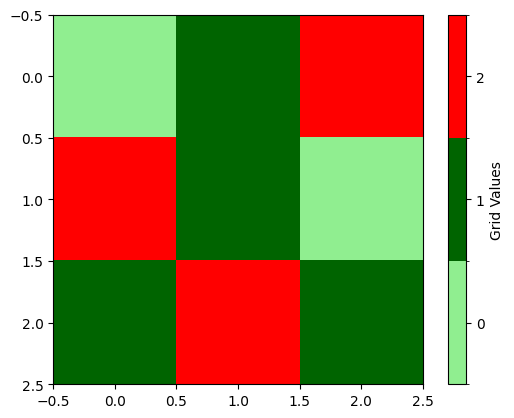

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a sample grid with values
grid = np.array([
    [0, 1, 2],
    [2, 1, 0],
    [1, 2, 1]
])

# Define custom colors for each value, e.g., 0 = light green, 1 = dark green, 2 = red
colors = ['lightgreen', 'darkgreen', 'red']
cmap = ListedColormap(colors)

# Set up boundaries for color mapping (adjusts range for each value)
bounds = [-0.5, 0.5, 1.5, 2.5]  # Boundaries for values 0, 1, and 2
norm = BoundaryNorm(bounds, cmap.N)

# Plot using imshow with custom colormap and normalization
fig, ax = plt.subplots()
im = ax.imshow(grid, cmap=cmap, norm=norm)

# Add a colorbar to see the mapping
plt.colorbar(im, ticks=[0, 1, 2], label="Grid Values")
plt.show()
